# Marketing Expenses Analysis
Analytical Department @ Yandex.Afisha

## Table of Contents <a id='back'></a>
* [Introduction](#intro)
* [Data Preparation](#data_prep)
* [Data Overview and Pre-processing](#preprocessing)
* [Metrics](#metrics)
    * [Product](#metrics_product)
        * [Active Users](#active_users)
        * [Session per Day](#daily_sessions)
        * [Lenght of Sessions](#session_length)
        * [Retention Rate](#retention_rate)
    * [Sales](#metrics_sales)
        * [Time to Conversion](#conversion)
        * [Number of Orders](#num_orders)
        * [Average Purchase Size](#purchase_size)
        * [Customer Lifetime Value](#ltv)
    * [Marketing](#metrics_marketing)
        * [Total Marketing Expenses](#expenses)
        * [Customer Acquisition Cost (CAC)](#cac)
        * [Return on Investment](#roi)
* [Conclusions](#conclusion)

## Introduction <a id='intro'></a>
Understanding customer behavior and optimimizing marketing strategies are crucial components for success of any online platform. At Yandex Afisha, we aim to enhance market presence while optimizing marketing expenses. This project seeks to analyze different product, sales and marketing metrics to understand how our customers behave and interact with the platform, enabling us to make informed decisions regarding our marketing allocation, so that it will lead to revenue growth and long-term customer relationships. 

**Business Question:**<br>
*How can we allocate our marketing budget to target users that exhibit higher purchase intent and lifetime values, thereby optimizing our marketing expenses?*

This question will guide our exploration and analysis to uncover patterns and trends in our data regarding our customers' behavior. For this analysis, we are using a dataset comprising server logs detailing users' visits and order records, spaning from Jun 2017 to May 2018, along with marketing expenses. Specifically, we are looking at how are the customers using the product, the revenue generated by customers, and the timing of our return on investments. 

 [⬆ Back to Contents](#back)

## Data Preparation <a id='data_prep'></a>

We will start by preparing our data for the analysis. Since we are working with large volumes of data, we'll optimize the data to avoid long times in calculation and system errors. We'll read a portion of each table (500 rows) to make changes in the data types and assess whether or not these changes lead to significant reductions in the size of the data.

In [1]:
import pandas as pd
import re

# Import necessary libraries for visualizations
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

In [2]:
try:
    visits = pd.read_csv('visits_log_us.csv', nrows=500)
except:
    visits = pd.read_csv('/datasets/visits_log_us.csv', nrows=500)
    
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Device     500 non-null    object
 1   End Ts     500 non-null    object
 2   Source Id  500 non-null    int64 
 3   Start Ts   500 non-null    object
 4   Uid        500 non-null    uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 113.1 KB


In [3]:
try:
    orders = pd.read_csv('orders_log_us.csv', nrows=500)
except: 
    orders = pd.read_csv('/datasets/orders_log_us.csv', nrows=500)
    
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   500 non-null    object 
 1   Revenue  500 non-null    float64
 2   Uid      500 non-null    uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 45.0 KB


In [4]:
try:
    costs = pd.read_csv('costs_us.csv', nrows=500)
except:
    costs = pd.read_csv('/datasets/costs_us.csv', nrows=500)
    
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  500 non-null    int64  
 1   dt         500 non-null    object 
 2   costs      500 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 40.7 KB


We can see that our `visits`, `orders`, and `costs` tables have a size of 113, 45 and 40 KB, respectively. We will later compare these sizes with the ones of the optimized data.

The `visits` table has 5 columns. The `Device` and `Source Id` columns are presumably categories, based on the description of the data. Let's look at the unique values of each.

In [5]:
visits['Device'].value_counts()

Device
desktop    363
touch      137
Name: count, dtype: int64

In [6]:
visits['Source Id'].value_counts()

Source Id
4     159
3     122
5      92
2      52
1      39
9      19
10     17
Name: count, dtype: int64

Since there are only two distinct values in the `Device` column, we will change its type from object to category, as the latter uses considerably less space. Since the `Source Id` column is `int` type, we will leave it as it is even though we don't need to perform numerical operation on it, as it doesn't make much difference in the size if changed to category.

In [7]:
visits['Device'] = visits['Device'].astype('category')

This table also has the columns `Start Ts` and `End Ts` containing date/time but stored as objects. Let's check the format of these columns and change the dtype to datetime.

In [8]:
visits.head()

Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

In [9]:
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format='%Y-%m-%d %H:%M:%S')
visits['End Ts'] = pd.to_datetime(visits['Start Ts'], format='%Y-%m-%d %H:%M:%S')

We will leave the column `Uid` as it is. Let's see the size of the new dataframe and compare its size to the original one.

In [10]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Device     500 non-null    category      
 1   End Ts     500 non-null    datetime64[ns]
 2   Source Id  500 non-null    int64         
 3   Start Ts   500 non-null    datetime64[ns]
 4   Uid        500 non-null    uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 16.5 KB


There was an incredible reduction of size in the `visits` table, from 113 KB to just around 16 KB. 

Let's continue with the `orders` table. This table only has 3 columns. We'll just change the dtype of the `Buy Ts` column to datetime and compare the difference in sizes.

In [11]:
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], format='%Y-%m-%d %H:%M:%S')

In [12]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   500 non-null    datetime64[ns]
 1   Revenue  500 non-null    float64       
 2   Uid      500 non-null    uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 11.8 KB


We can also see a significant reduction from 45 KB to less than 12 KB.

Lastly, we'll make the necesarry changes in the `costs` tables. This table also has 3 columns. Like in the previous ones, there is one column with date/time values stored as object dtype. There is also a column, `source_id`, which might be converted to category. Let's check the unique values.

In [13]:
costs['source_id'].value_counts()

source_id
1    363
2    137
Name: count, dtype: int64

There are only two values, but since we're only reviewing the beginning of the table, there are presumably 7 like in the `visits` table. Since we did not change it in the `visits` table, we'll also leave unchenged here. Let's update the dtype of `dt` column and see the difference in size after the change.

In [14]:
costs['dt'].head()

0    2017-06-01
1    2017-06-02
2    2017-06-03
3    2017-06-04
4    2017-06-05
Name: dt, dtype: object

In [15]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

In [16]:
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  500 non-null    int64         
 1   dt         500 non-null    datetime64[ns]
 2   costs      500 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.8 KB


Similar to the previous tables, this one also presents a significant reduction in size, from 41 KB to less than 12 KB. These changes will be much more significant once we read the complete tables. Now that we know these changes make a difference in the sizes of the dataframes, let's read the whole tables with the correct data types. 

In [17]:
try:
    visits = pd.read_csv(
        'visits_log_us.csv',
        dtype={'Device': 'category'},
        parse_dates=['Start Ts', 'End Ts'],
    )
except:
    visits = pd.read_csv(
        '/datasets/visits_log_us.csv',
        dtype={'Device': 'category'},
        parse_dates=['Start Ts', 'End Ts'],
    )

visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [18]:
try:
    orders = pd.read_csv(
        'orders_log_us.csv',
        parse_dates=['Buy Ts'],
    )
except:
    orders = pd.read_csv(
        '/datasets/orders_log_us.csv',
        parse_dates=['Buy Ts'],
    )

orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [19]:
try:
    costs = pd.read_csv(
        'costs_us.csv',
        parse_dates=['dt'],
    )
except:
    costs = pd.read_csv(
        '/datasets/costs_us.csv',
        parse_dates=['dt'],
    )
    
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Although the `costs` table is relatively small, with around 2500 entries, the `visits` and `orders` tables are relatively big, with more than 350,000 and 50,000 entries, respectively. With the optimization made, we will be able to perform the analysis in a more efficient way.

 [⬆ Back to Contents](#back)

## Data Overview and Pre-processing <a id='preprocessing'></a>

We already had an initial overview of the data and we know the number of columns and rows for each table. We also know that the data types are correct for each column. Additionally, we can see that there are no missing values in any columns. However, we can see that there are some issues with the style in the column names. We find that there are names that use uppercase letters at the beginning of the words and that those column names with more than one word are separated by spaces.

Let's use a function that we have already defined (in Sprint 5) to change the column names of `visits` and `orders` to snake case. The `costs` table does not need any change. 

In [20]:
# renaming columns to snake case
def renaming_columns(columns):
    '''
    Rename the columns of a dataframe by separating camelCase, removing leading and trailing spaces,
    changing to lowercase, and replacing spaces between words with underscores for snake case.
    
    parameters: columns - a list of the original headers of the dataframe.
    
    returns: a dictionary with the the original headers as keys and cleaned headers as items.
    '''
    
    new_headers = {}
    
    for header in columns:
        new_header = re.sub(r'([a-z])([A-Z])', r'\1 \2', header)  #split camel case into sep words
        new_header = new_header.strip().lower().replace(' ', '_') 
        new_headers[header] = new_header
        
    return new_headers

In [21]:
# Renaming the columns for the visits table
columns = visits.columns
columns_clean = renaming_columns(columns)          

visits = visits.rename(columns = columns_clean)
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [22]:
# Renaming the columns for the orders table
columns = orders.columns
columns_clean = renaming_columns(columns)          

orders = orders.rename(columns = columns_clean)
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

We have successfully changed the names of the columns for an easier manipulation of the data.

Let's proceed to check if we have duplicated values.

In [23]:
visits.duplicated().sum()

0

In [24]:
orders.duplicated().sum()

0

In [25]:
costs.duplicated().sum()

0

We do not have duplicated entries in any of the tables. Let's continue by checking that the dates in every table correspond to the period we are analyzing, by checking the max and min values.

In [26]:
min_start = visits['start_ts'].dt.date.min()
max_start = visits['start_ts'].dt.date.max()
min_end = visits['end_ts'].dt.date.min()
max_end = visits['end_ts'].dt.date.max()

print(f'The session start dates of the visits table range between {min_start} and {max_start}')
print(f'The session end dates of the visits table range between {min_end} and {max_end}')

The session start dates of the visits table range between 2017-06-01 and 2018-05-31
The session end dates of the visits table range between 2017-06-01 and 2018-06-01


All the start session dates fall in the range. There are sessions that ended on the 1st of June, 2018, pressumably sessions that started late on may 31 and ended at the beginning of June 1st. Let's verify that.

In [27]:
visits[visits['end_ts'].dt.date > pd.to_datetime('2018-05-31').date()]

device              end_ts  source_id            start_ts  \
2330    desktop 2018-06-01 00:05:00          2 2018-05-31 23:30:00   
43215   desktop 2018-06-01 00:13:00          4 2018-05-31 23:46:00   
46667   desktop 2018-06-01 00:13:00          5 2018-05-31 23:48:00   
154728  desktop 2018-06-01 00:09:00          2 2018-05-31 22:52:00   
198329  desktop 2018-06-01 00:11:00          3 2018-05-31 23:59:00   
216791    touch 2018-06-01 00:06:00          5 2018-05-31 23:45:00   
263781  desktop 2018-06-01 00:25:00          1 2018-05-31 23:59:00   
269213    touch 2018-06-01 00:12:00         10 2018-05-31 23:59:00   
288563    touch 2018-06-01 00:01:00          4 2018-05-31 23:37:00   
299620  desktop 2018-06-01 00:04:00          4 2018-05-31 23:59:00   
342205    touch 2018-06-01 01:26:00          1 2018-05-31 23:44:00   
355366  desktop 2018-06-01 00:00:00          4 2018-05-31 23:54:00   

                         uid  
2330     5300693976971713685  
43215   12296626599487328624  
46667    1107134732939577311  
154728  12484396335714047199  
198329   3720373600909378583  
216791   9951896961656595558  
263781   4906562732540547408  
269213  10723414689244282024  
288563   1094281763368510391  
299620     83872787173869366  
342205  13670831770959132678  
355366  17972575701705277137

As expected, the few sessions 'out of range' indeed started on May 31st and ended in the early morning of June 1st. Let's make sure that all the sessions have a date and time previous to the end of the session.

In [28]:
visits[visits['start_ts'] > visits['end_ts']]

device              end_ts  source_id            start_ts  \
4181    desktop 2018-03-25 03:18:00          3 2018-03-25 03:50:00   
177972  desktop 2018-03-25 03:09:00          9 2018-03-25 03:55:00   

                         uid  
4181    13092152539246794986  
177972   4621202742905035453

There are two entries where the start time occurred later than the end time. This might be due to system errors. Since there are only two such entries, we will proceed to drop them.

In [29]:
visits = visits.drop(visits[visits['start_ts'] > visits['end_ts']].index).reset_index()
visits.shape

(359398, 6)

In [30]:
min_buy_dt = orders['buy_ts'].dt.date.min()
max_buy_dt = orders['buy_ts'].dt.date.max()

print(f'The order dates from the orders table range between {min_buy_dt} and {max_buy_dt}')

The order dates from the orders table range between 2017-06-01 and 2018-06-01


In [31]:
orders[orders['buy_ts'].dt.date > pd.to_datetime('2018-05-31').date()]

buy_ts  revenue                uid
50414 2018-06-01 00:02:00     3.42  83872787173869366

We have one order placed on June 2018, but we already know that it is from a session that started on May.

In [32]:
min_cost = costs['dt'].min()
max_cost = costs['dt'].max()

print(f'The dates from the costs table range between {min_cost} and {max_cost}')

The dates from the costs table range between 2017-06-01 00:00:00 and 2018-05-31 00:00:00


All the data seem to be correct. We will now preceed to explore the data and calculate the metrics for our analysis.

 [⬆ Back to Contents](#back)


## Metrics <a id='metrics'></a>

In this section, we will examine various core metrics, to gain a better understanding and evaluate key aspects of product engagement, sales conversion, and marketing effectiveness. By exploring these metrics, we aim to uncover actionable insights that will inform strategic decisions and optimize resource allocation. 

### Metrics: Product <a id='metrics_product'></a>

Understanding how customer utilize our platform is fundamental to enhancing user experience and satisfaction. Let's start by calculating the Daily, Weekly and Monthly Active Users:

#### Active Users <a id='active_users'></a>

In [33]:
# Creating columns for grouping
visits['session_year'] = visits['start_ts'].dt.isocalendar().year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.isocalendar().week
visits['session_date'] =  visits['start_ts'].dt.floor('D')

In [34]:
visits.head()

index   device              end_ts  source_id            start_ts  \
0      0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1      1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2      2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3      3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4      4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid  session_year  session_month  session_week  \
0  16879256277535980062          2017             12            51   
1    104060357244891740          2018              2             8   
2   7459035603376831527          2017              7            26   
3  16174680259334210214          2018              5            20   
4   9969694820036681168          2017             12            52   

  session_date  
0   2017-12-20  
1   2018-02-19  
2   2017-07-01  
3   2018-05-20  
4   2017-12-27

In [35]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359398 entries, 0 to 359397
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   index          359398 non-null  int64         
 1   device         359398 non-null  category      
 2   end_ts         359398 non-null  datetime64[ns]
 3   source_id      359398 non-null  int64         
 4   start_ts       359398 non-null  datetime64[ns]
 5   uid            359398 non-null  uint64        
 6   session_year   359398 non-null  UInt32        
 7   session_month  359398 non-null  int32         
 8   session_week   359398 non-null  UInt32        
 9   session_date   359398 non-null  datetime64[ns]
dtypes: UInt32(2), category(1), datetime64[ns](3), int32(1), int64(2), uint64(1)
memory usage: 21.6 MB


In [36]:
# daily active (unique) users
dau = visits.groupby('session_date').agg({'uid': 'nunique'})
dau = dau.rename(columns={'uid': 'users_cnt'})

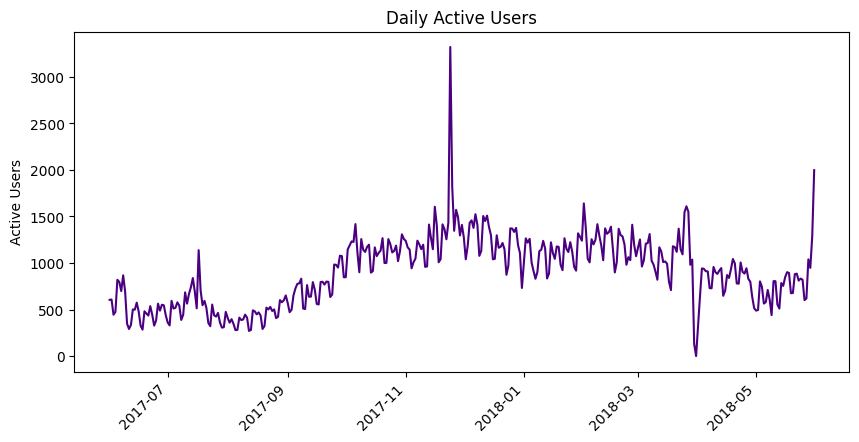

The mean of Daily Active Users is 908.


In [37]:
# plot daily active users
dau_plot = dau.plot(kind='line', figsize=(10,5), rot=45, legend=False, color='indigo')

plt.title('Daily Active Users')
plt.xlabel('')
plt.ylabel('Active Users')

plt.show()

dau_mean = dau['users_cnt'].mean()
print(f'The mean of Daily Active Users is {dau_mean:.0f}.')

We can see a steady increase from around the beginning of Aug 2017, until there is a peak around the end of November. Following this peak, the number of active users seems to be consistent, with a slight decrease for the last two months, followed by a second peak towards the end of May.

In [38]:
# weekly active users
wau = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'})
wau = wau.rename(columns={'uid': 'users_cnt'})

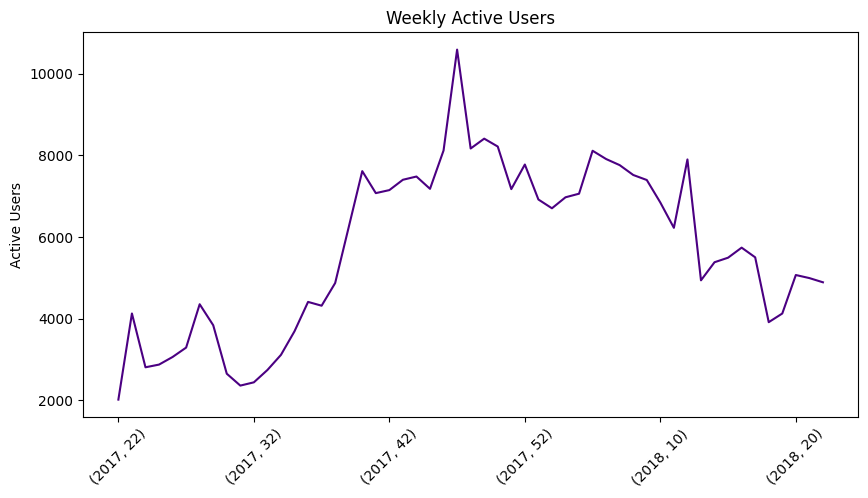

The mean of Weekly Active Users is 5716.


In [39]:
# plot weekly active users
wau_plot = wau.plot(kind='line', figsize=(10,5), rot=45, legend=False, color='indigo')
plt.title('Weekly Active Users')
plt.xlabel('')
plt.ylabel('Active Users')

plt.show()

wau_mean = wau['users_cnt'].mean()
print(f'The mean of Weekly Active Users is {wau_mean:.0f}.')

The weekly active users shows a similar trend.

In [40]:
# montly active users
mau = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'})
mau = mau.rename(columns={'uid': 'users_cnt'})

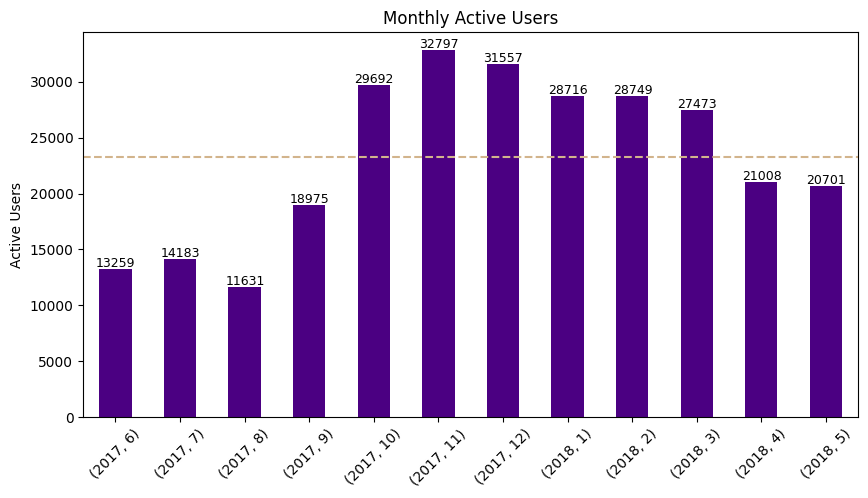

The mean of Monthly Active Users is 23228.


In [41]:
# plot monthly active users
mau_mean = mau['users_cnt'].mean()

mau_plot = mau.plot(kind='bar', figsize=(10,5), rot=45, legend=False, color='indigo')

mau_plot.axhline(mau_mean, color='tan', linestyle='--', label='Mean')


plt.title('Monthly Active Users')
plt.xlabel('')
plt.ylabel('Active Users')

for i, y in enumerate(mau['users_cnt']):
    plt.text(i - 0.3, y+200, s=str(round(y, 2)), fontsize=9)

plt.show()

print(f'The mean of Monthly Active Users is {mau_mean:.0f}.')

When looking at the monthly number of active users, we can see that the last three and first three months of the year present higher than average activity. As we saw in the daily activity, there was a day with a peak on November, presumably due to a special activity. Although these metrics don't provide much information regarding app functions, it does suggest higher user activity in autumn and winter.

In [42]:
sticky_factor_w = (round(dau_mean/wau_mean, 5))*100
sticky_factor_w

15.884

In [43]:
sticky_factor_m = (round(dau_mean/mau_mean, 4))*100
sticky_factor_m

3.91

The sticky factor for the week suggests that, on average, a relatively small proportion of the weekly active users are returning to the product on a daily basis (around 16%). Likewise, the sticky factor for the month indicates a relatively low level of daily engagement compared to the monthly user base (around 4%).

 [⬆ Back to Contents](#back)

#### Sessions per Day <a id='daily_sessions'></a>

Let's dive into how many sessions are there per day, knowing that one user might have more than one session.

In [44]:
# average number of sessions per user per date
sessions_per_date = visits.groupby('session_date', as_index=False).agg(sessions_cnt=('uid', 'count'), users_cnt=('uid', 'nunique'))
sessions_per_date['sessions_per_user'] = (sessions_per_date['sessions_cnt']/sessions_per_date['users_cnt'])

# average number of session per user overall
mean_sessions_daily = sessions_per_date['sessions_cnt'].sum() / sessions_per_date['users_cnt'].sum()

print(f'The average number of sessions per user is {mean_sessions_daily:.2f}.')
sessions_per_date.sample(10)

The average number of sessions per user is 1.09.


session_date  sessions_cnt  users_cnt  sessions_per_user
86    2017-08-26           425        409           1.039120
34    2017-07-05           566        519           1.090559
249   2018-02-05          1356       1256           1.079618
347   2018-05-15           832        755           1.101987
282   2018-03-10           984        908           1.083700
13    2017-06-14           547        499           1.096192
114   2017-09-23           669        635           1.053543
235   2018-01-22          1399       1266           1.105055
73    2017-08-13           293        281           1.042705
111   2017-09-20           837        769           1.088427

The average sessions per day higher than 1 indicates that there are days where some users are having more than one session. That does not necessarily mean that all users are active every day. 

In [45]:
# plot average number of sessions per user per day
sessions_fig = px.line(sessions_per_date,
              x='session_date',
              y='sessions_per_user',
              width=900,
              height=500,
              title='Sessions per User',
              hover_data=['sessions_cnt', 'users_cnt']
             )
sessions_fig.show()

From this plot, we can see that the number of sessions per day seems to be relatively stable, being the average number of sessions per user equal or higher than 1 and up to 1.2 for every day. This indicates that there are some users having more than one session on each day. Let's visualize the distribution of all the sessions with a boxplot.

In [46]:
# plot distribution of number of sessions
box_fig = px.box(sessions_per_date,
                y="sessions_cnt",
                hover_data=['session_date', 'users_cnt'])

box_fig.update_layout(width=600, 
                height=500,
                yaxis_title='Num of sessions',
                title='Daily Sessions')

box_fig.show()

We can see that the peaks previously identified are clearly outliers, when accounting for all the visits in all of the dates. Let's calculate the number of sessions per user per month.

In [47]:
sessions_per_month = visits.groupby(['session_year', 'session_month']).agg({'uid': ['count', 'nunique']})
sessions_per_month.columns = sessions_per_month.columns.droplevel(level=0)
sessions_per_month.columns = ['n_sessions', 'n_users']
sessions_per_month = sessions_per_month.reset_index() 

sessions_per_month['session_Ym'] = sessions_per_month['session_year'].astype(str)+ '-' + sessions_per_month['session_month'].astype(str)
sessions_per_month.set_index(['session_year', 'session_month'], inplace=True)

sessions_per_month['sessions_per_user'] = sessions_per_month['n_sessions'] / sessions_per_month['n_users']

sessions_per_month

n_sessions  n_users session_Ym  sessions_per_user
session_year session_month                                                   
2017         6                   16505    13259     2017-6           1.244815
             7                   17828    14183     2017-7           1.256998
             8                   14355    11631     2017-8           1.234202
             9                   23907    18975     2017-9           1.259921
             10                  37903    29692    2017-10           1.276539
             11                  43969    32797    2017-11           1.340641
             12                  41983    31557    2017-12           1.330386
2018         1                   36939    28716     2018-1           1.286356
             2                   37182    28749     2018-2           1.293332
             3                   35677    27473     2018-3           1.298620
             4                   26515    21008     2018-4           1.262138
             5                   26635    20701     2018-5           1.286653

In [48]:
fig = px.line(sessions_per_month,
              x='session_Ym',
              y='sessions_per_user',
              title='Sessions per User per Month'
             )
fig.show()

The average number of sessions per user per month falls between 1.2 and 1.3, indicating relatively consistent visiting behavior over this period. Users tend to have one session per month, with only a few having more than one session. This suggests that periods with higher numbers of active users may be due to new user acquisition rather than increased visits from existing users.

 [⬆ Back to Contents](#back)

#### Length of Sessions <a id='session_length'></a>

Let's calculate the length of each session and the average session length (ASL).

In [49]:
# session length for each session in minutes
sessions_len = visits[['uid', 'start_ts', 'end_ts']]
sessions_len['duration_mins'] = ((sessions_len['end_ts'] - sessions_len['start_ts']).dt.seconds / 60).astype('int')

# mean duration of session length
mean_duration = sessions_len['duration_mins'].mean()
print(f'The mean duration of the sessions is {mean_duration:.2f} minutes.')

sessions_len.sample(10)

The mean duration of the sessions is 10.72 minutes.


/var/folders/mg/hptp2zld5cl6kjcrwfys_p5h0000gn/T/ipykernel_62701/2103058259.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



uid            start_ts              end_ts  \
344162   5905941079213880107 2017-10-25 11:20:00 2017-10-25 11:32:00   
209543   3904980804797498665 2018-01-28 19:00:00 2018-01-28 19:01:00   
158394   4540169542651341080 2018-02-12 17:38:00 2018-02-12 17:39:00   
356900  16609030005109833765 2017-07-12 23:00:00 2017-07-12 23:04:00   
232157  14021064755548680196 2017-12-20 22:40:00 2017-12-20 22:47:00   
206411  14534307313925210432 2017-08-07 13:52:00 2017-08-07 13:52:00   
206452  11616947936617491261 2017-09-27 16:54:00 2017-09-27 17:10:00   
1139    14713624710095915718 2017-10-01 11:50:00 2017-10-01 11:51:00   
203368  15358483531863303341 2017-12-29 00:10:00 2017-12-29 01:09:00   
200115   7225816581950080786 2018-01-09 15:45:00 2018-01-09 15:48:00   

        duration_mins  
344162             12  
209543              1  
158394              1  
356900              4  
232157              7  
206411              0  
206452             16  
1139                1  
203368             59  
200115              3

Let's look a the distribution:

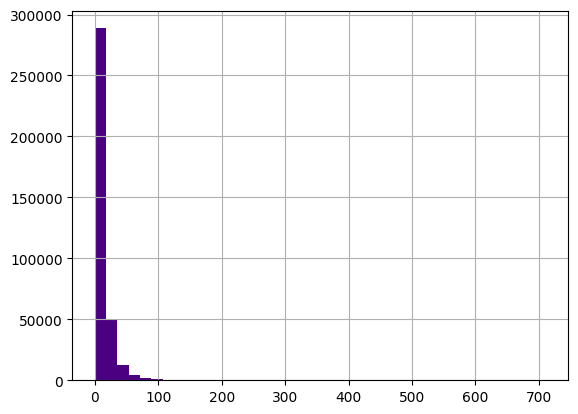

In [50]:
sessions_len['duration_mins'].hist(bins=40, color='indigo')
plt.show()

Since the distribution is not normal, let's find the mode to determine the the most common session length.

In [51]:
session_mode = sessions_len['duration_mins'].mode().values[0]
print(f'The most common session legth is {session_mode} minute.')

The most common session legth is 1 minute.


We can also take a look at the Average Session Length per user.

In [52]:
len_per_user = sessions_len.groupby('uid').agg(total_duration = ('duration_mins', 'sum'), n_sessions = ('uid', 'count')).reset_index()
len_per_user['avg_duration'] = (len_per_user['total_duration'] / len_per_user['n_sessions']).astype('int')
len_per_user.sort_values(by='avg_duration', ascending=False)
len_per_user.head(10)

uid  total_duration  n_sessions  avg_duration
0   11863502262781               6           1             6
1   49537067089222               2           1             2
2  297729379853735               1           1             1
3  313578113262317              33           3            11
4  325320750514679              10           2             5
5  397399764396656               1           1             1
6  407573351275847               5           1             5
7  498809019029702               2           1             2
8  526778907996220              83           4            20
9  577434573913691              18           2             9

In [53]:
# plot session len per user
fig = px.histogram(len_per_user, x='avg_duration', nbins=40, color_discrete_sequence=['indigo'])

fig.show()

session_user_mode = len_per_user['avg_duration'].mode().values[0]
print(f'The most common session length is {session_user_mode} minutes.')

The most common session length is 1 minutes.


The majority of the users have sessions shorter than 10 minutes, being 1 minute the most common session length.

 [⬆ Back to Contents](#back)

#### User Retention Rate <a id='retention_rate'></a>

The retention rate is another important metric that can help us analyze the effectiveness of our marketing campaigns. To calculate it, we'll start by dividing the users in monthly cohorts.

In [54]:
# first daty of activity for every user
first_activity = visits.groupby('uid').agg({'session_date': 'min'}).reset_index()
first_activity.columns = ['uid', 'first_activity_date']
first_activity['first_activity_month'] = first_activity['first_activity_date'].dt.to_period('M').dt.to_timestamp()

# adding first activity date to original table -- visits
cohorts_month = visits[['uid', 'session_date']]
cohorts_month = cohorts_month.merge(first_activity, on='uid')

In [55]:
cohorts_month.head()

uid session_date first_activity_date first_activity_month
0  16879256277535980062   2017-12-20          2017-12-20           2017-12-01
1    104060357244891740   2018-02-19          2018-02-19           2018-02-01
2   7459035603376831527   2017-07-01          2017-07-01           2017-07-01
3  16174680259334210214   2018-05-20          2018-03-09           2018-03-01
4  16174680259334210214   2018-03-09          2018-03-09           2018-03-01

In [56]:
# getting the cohort (the month of the first activity) and the month of each activiry
cohorts_month['session_month'] = cohorts_month['session_date'].dt.to_period('M').dt.to_timestamp()
cohorts_month['cohort'] = cohorts_month['first_activity_date'].dt.to_period('M').dt.to_timestamp()

# getting lifetime age for each activity of every user
cohorts_month['cohort_lifetime'] = (cohorts_month['session_month'] - cohorts_month['cohort']) / np.timedelta64(1, 'M')
cohorts_month['cohort_lifetime'] = cohorts_month['cohort_lifetime'].round().astype('int')

cohorts_month.sample(5)

uid session_date first_activity_date  \
234780  1203418507481400078   2017-08-26          2017-08-26   
320134  8661890566792667168   2017-11-23          2017-10-09   
274657  7518960270333082973   2017-12-07          2017-12-07   
188366  7913544859530881410   2017-07-31          2017-07-31   
252706  9286401440992414917   2018-01-18          2018-01-18   

       first_activity_month session_month     cohort  cohort_lifetime  
234780           2017-08-01    2017-08-01 2017-08-01                0  
320134           2017-10-01    2017-11-01 2017-10-01                1  
274657           2017-12-01    2017-12-01 2017-12-01                0  
188366           2017-07-01    2017-07-01 2017-07-01                0  
252706           2018-01-01    2018-01-01 2018-01-01                0

In [57]:
# getting number of users from each cohort that had activity on each month
cohorts = cohorts_month.groupby(['cohort', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
cohorts = cohorts.rename(columns={'uid': 'uid_cnt'})
cohorts.head()

cohort  cohort_lifetime  uid_cnt
0 2017-06-01                0    13259
1 2017-06-01                1     1043
2 2017-06-01                2      713
3 2017-06-01                3      814
4 2017-06-01                4      909

In [58]:
users_by_cohort = cohorts.pivot_table(
    index='cohort',
    columns='cohort_lifetime',
    values='uid_cnt'                             
)
users_by_cohort.fillna('')

cohort_lifetime       0       1       2       3      4      5      6      7   \
cohort                                                                         
2017-06-01       13259.0  1043.0   713.0   814.0  909.0  947.0  809.0  766.0   
2017-07-01       13140.0   737.0   674.0   738.0  765.0  633.0  596.0  601.0   
2017-08-01       10181.0   783.0   640.0   639.0  510.0  448.0  370.0  402.0   
2017-09-01       16704.0  1428.0  1156.0   847.0  658.0  632.0  599.0  404.0   
2017-10-01       25977.0  2042.0  1357.0  1012.0  890.0  837.0  555.0  529.0   
2017-11-01       27248.0  2133.0  1202.0  1054.0  919.0  638.0  594.0          
2017-12-01       25268.0  1410.0   960.0   786.0  512.0  481.0                 
2018-01-01       22624.0  1351.0   890.0   565.0  458.0                        
2018-02-01       22197.0  1267.0   565.0   446.0                               
2018-03-01       20589.0   861.0   557.0                                       
2018-04-01       15709.0   760.0                                               
2018-05-01       15273.0                                                       

cohort_lifetime     8      9      10     11  
cohort                                       
2017-06-01       694.0  674.0  539.0  596.0  
2017-07-01       510.0  376.0  361.0         
2017-08-01       284.0  265.0                
2017-09-01       381.0                       
2017-10-01                                   
2017-11-01                                   
2017-12-01                                   
2018-01-01                                   
2018-02-01                                   
2018-03-01                                   
2018-04-01                                   
2018-05-01

To calculate the retention rate, we first need to retrieve the initial number of users in each cohort and divide it by the number of users for each subsequent month. 

In [59]:
# getting cohort size
initial_user_count = cohorts[cohorts['cohort_lifetime'] == 0][['cohort', 'uid_cnt']]
initial_user_count.columns = ['cohort', 'initial_user_cnt']

#initial_user_count

In [60]:
cohorts = cohorts.merge(initial_user_count, on='cohort')

In [61]:
# calculating retention for each period.
cohorts['retention'] = (cohorts['uid_cnt'] / cohorts['initial_user_cnt']).round(3)

In [62]:
retention_pivot = cohorts.pivot_table(
                index='cohort',
                columns='cohort_lifetime',
                values='retention'
)

#retention_pivot.fillna('')

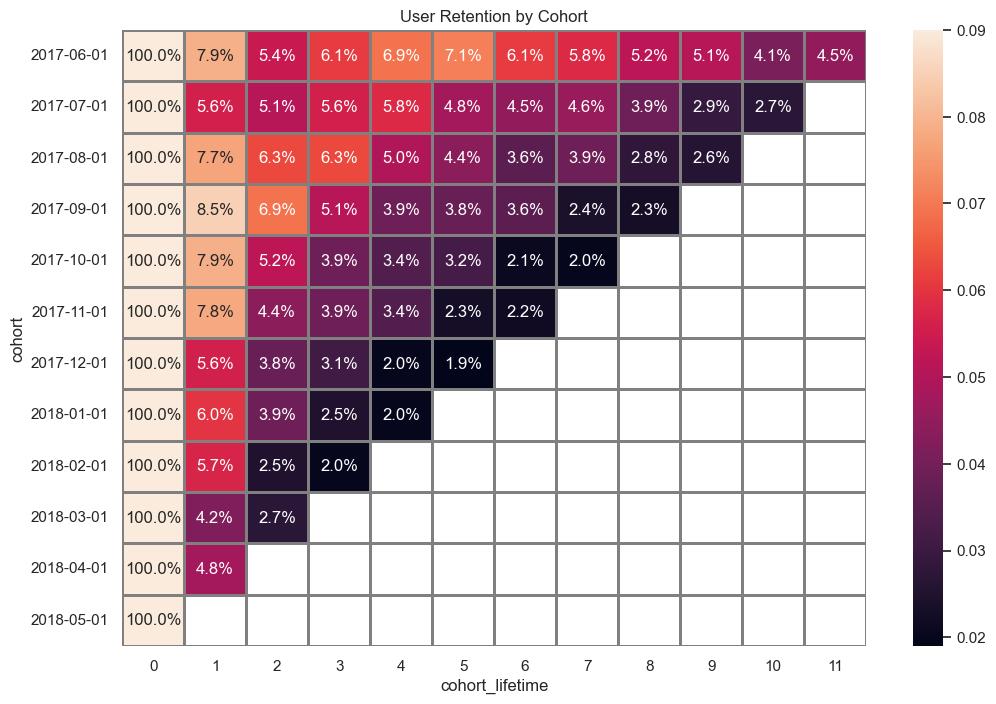

In [63]:
sns.set(style='white')

retention_pivot.index=retention_pivot.index.astype(str)

plt.figure(figsize=(12, 8))
plt.title('User Retention by Cohort')
sns.heatmap(
    retention_pivot, annot=True, fmt='.1%', vmax=0.09, linewidths=1, linecolor='gray'
)

plt.show()

The retention rate drops dramatically after one month for every cohort, particularly for the cohorts after Dec 2017. The cohorts between June and November 2017 are the ones with the higher retention rate for the first month (with the exception of July). In general, the retention rate keeps droping after each month, with some minor exceptions. It seem that the retention rates are dropping faster for every subsequent cohort, most of them falling to 2-3% faster than the previous one.

 [⬆ Back to Contents](#back)

### Metrics: Sales <a id='metrics_sales'></a>

The sales journey is a critical aspect of customer interaction, and the associated metrics will also guide us in the undestanding of the values derived from each customer. We will analyze the time to conversion, how many orders are made in a given period of time, the amount each cohort spend in each period and the average revenue generated from each cohort.

#### Time to Conversion <a id='conversion'><a/>

First, we will calculate the time elapsed between the registration and the first purchase. This can help us understand the effectiveness of conversion strategies and identify optimal conversion windows. Let's start by getting the date of the first purhase for every user, to later compare it with the first date of activity in the plarform.

In [64]:
# getting the first order date for each user
purchases = orders.groupby('uid').agg(first_purchase=('buy_ts', 'min')).reset_index()
purchases['first_purchase'] = purchases['first_purchase'].dt.floor('D')

In [65]:
# comparing first order date to first activity date -- time to conversion
first_buy = first_activity.merge(purchases, how='inner')

first_buy['conversion_days'] = round((first_buy['first_purchase'] - first_buy['first_activity_date']) / np.timedelta64(1, 'D'), 0).astype('int')
first_buy.sample(10)

uid first_activity_date first_activity_month  \
27329  13804300209435121842          2018-02-17           2018-02-01   
30199  15225963158458306022          2018-05-09           2018-05-01   
13572   6795790526120102371          2018-05-30           2018-05-01   
23510  11868684522001559241          2017-07-02           2017-07-01   
27893  14104224300861461759          2017-11-17           2017-11-01   
32005  16154749372541458901          2017-12-02           2017-12-01   
25436  12848799056143536720          2017-10-02           2017-10-01   
32925  16621399579757492669          2017-07-13           2017-07-01   
2661    1367240964134580648          2018-04-02           2018-04-01   
33192  16759154592150841785          2017-12-31           2017-12-01   

      first_purchase  conversion_days  
27329     2018-02-17                0  
30199     2018-05-09                0  
13572     2018-05-30                0  
23510     2017-07-02                0  
27893     2017-11-17                0  
32005     2018-01-05               34  
25436     2017-10-02                0  
32925     2017-07-13                0  
2661      2018-04-02                0  
33192     2017-12-31                0

In [66]:
fig = px.histogram(first_buy, x='conversion_days', nbins=40, color_discrete_sequence=['indigo'])
fig.show()

We can see that most of the users convert to customers between 0 to 9 days after registration.

In [67]:
first_buy['conversion_days'].value_counts(normalize=True).head()

conversion_days
0    0.685568
1    0.053829
2    0.018755
3    0.012376
4    0.010569
Name: proportion, dtype: float64

Looking at the proportion, we can see that almost 70% of the users convert to customers on day 0. This could suggest that most of the users come to the platform for the first time and register with the intention to make a purchase.

In [68]:
conversion = (orders['uid'].nunique() / visits['uid'].nunique())*100
print(f'The total conversion rate is {conversion:.2f}%.')

The total conversion rate is 16.01%.


Let's explore the conversion rate by cohort.

In [69]:
# getting the month of the first order for every user
first_purchase = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_purchase.columns = ['uid', 'first_purchase']

first_purchase['first_purchase'] = first_purchase['first_purchase'].dt.floor('D')
first_purchase['first_purchase_month'] = first_purchase['first_purchase'].dt.to_period('M').dt.to_timestamp()

first_purchase.head()

uid first_purchase first_purchase_month
0   313578113262317     2018-01-03           2018-01-01
1  1575281904278712     2017-06-03           2017-06-01
2  2429014661409475     2017-10-11           2017-10-01
3  2464366381792757     2018-01-28           2018-01-01
4  2551852515556206     2017-11-24           2017-11-01

In [70]:
# calculating number of months between first activity and firts order
cohort_conversion = first_activity.merge(first_purchase, on='uid', how='left')

cohort_conversion['age'] = (cohort_conversion['first_purchase_month'] - cohort_conversion['first_activity_month']) / np.timedelta64(1, 'M')
cohort_conversion['age'] = round(cohort_conversion['age'], 0)

cohort_conversion.head()

uid first_activity_date first_activity_month first_purchase  \
0   11863502262781          2018-03-01           2018-03-01            NaT   
1   49537067089222          2018-02-06           2018-02-01            NaT   
2  297729379853735          2017-06-07           2017-06-01            NaT   
3  313578113262317          2017-09-18           2017-09-01     2018-01-03   
4  325320750514679          2017-09-30           2017-09-01            NaT   

  first_purchase_month  age  
0                  NaT  NaN  
1                  NaT  NaN  
2                  NaT  NaN  
3           2018-01-01  4.0  
4                  NaT  NaN

In [71]:
# getting month of first activity
first_activity['first_activity_month'] = first_activity['first_activity_date'].dt.to_period('M').dt.to_timestamp()

In [72]:
conversion_pivot = cohort_conversion.pivot_table(
                    index='first_activity_month',
                    columns='age',
                    values='uid',
                    aggfunc='nunique')
#conversion_pivot.fillna('')

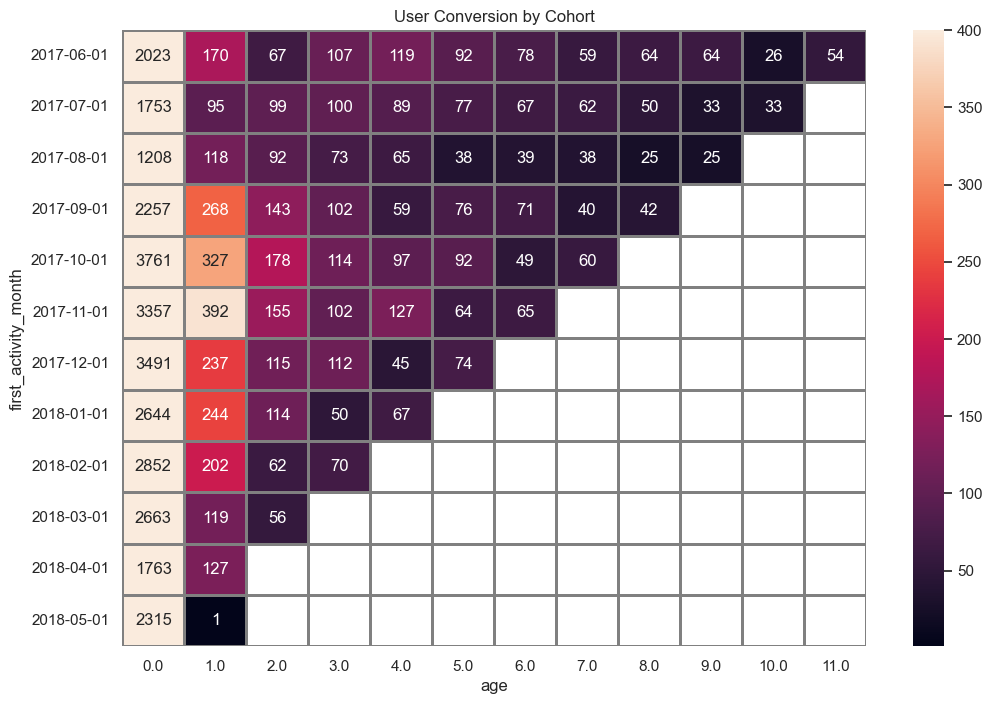

In [73]:
conversion_pivot.index=conversion_pivot.index.astype(str)

plt.figure(figsize=(12, 8))
plt.title('User Conversion by Cohort')
sns.heatmap(
    conversion_pivot, annot=True, fmt='.0f', vmax=400, linewidths=1, linecolor='gray'
)

plt.show()

For each cohort, the main purchase activity happens in the first month or registration. The graph suggests that the likelihood of an user becoming a customer after the first months decreases drastically, and keeps decreasing each subsequent month.

 [⬆ Back to Contents](#back)

#### Number of Orders <a id='num_orders'></a>

To calculate how many orders the customers made in a given period of time, let's calculate new cohorts for the customers, based on the month of their first order.

In [74]:
# creating cohorts based on first order month
purchase_cohort = orders.merge(purchases, on='uid', how='left')

purchase_cohort['buy_ts'] = purchase_cohort['buy_ts'].dt.floor('D')
purchase_cohort['purchase_month'] = purchase_cohort['buy_ts'].dt.to_period('M').dt.to_timestamp()

purchase_cohort['cohort'] = purchase_cohort['first_purchase'].dt.to_period('M').dt.to_timestamp()
purchase_cohort['lifetime'] = (purchase_cohort['purchase_month'] - purchase_cohort['cohort']) / np.timedelta64(1, 'M')
purchase_cohort['lifetime'] = purchase_cohort['lifetime'].round().astype('int')

purchase_cohort.sample(10)

buy_ts  revenue                   uid first_purchase purchase_month  \
28546 2018-01-08    12.22  10343016064897450067     2017-12-07     2018-01-01   
12050 2017-10-10    74.92  15046505774730997362     2017-09-12     2017-10-01   
33710 2018-02-09     1.54   9592682199004628415     2017-09-07     2018-02-01   
44371 2018-04-17     2.22  12773399121558705013     2018-04-17     2018-04-01   
49541 2018-05-29     3.05   6908973017948782508     2018-05-29     2018-05-01   
32229 2018-02-01     1.83  13593317518771351030     2018-02-01     2018-02-01   
39740 2018-03-13     1.59  12849119695099180193     2018-03-13     2018-03-01   
42199 2018-03-26     2.04  14560017819870372394     2018-03-25     2018-03-01   
9786  2017-09-30     0.98  12289967133758192045     2017-09-27     2017-09-01   
38156 2018-03-04    11.00  10805153392639169663     2018-03-04     2018-03-01   

          cohort  lifetime  
28546 2017-12-01         1  
12050 2017-09-01         1  
33710 2017-09-01         5  
44371 2018-04-01         0  
49541 2018-05-01         0  
32229 2018-02-01         0  
39740 2018-03-01         0  
42199 2018-03-01         0  
9786  2017-09-01         0  
38156 2018-03-01         0

In [75]:
orders_pivot = purchase_cohort.pivot_table(
                index='cohort',
                columns='lifetime',
                values='uid',
                aggfunc='count'
)
orders_pivot.fillna('')

lifetime        0      1      2      3      4      5      6      7      8   \
cohort                                                                       
2017-06-01  2354.0  177.0  174.0  226.0  292.0  218.0  276.0  174.0  212.0   
2017-07-01  2186.0  100.0  120.0  104.0   72.0   82.0   61.0   50.0   58.0   
2017-08-01  1533.0  108.0  100.0   81.0   85.0   62.0   49.0   78.0   46.0   
2017-09-01  2933.0  219.0  161.0  164.0   67.0  109.0  108.0   56.0   61.0   
2017-10-01  4964.0  314.0  162.0  122.0  129.0  103.0   86.0  125.0          
2017-11-01  4813.0  397.0  182.0  211.0  136.0   59.0  102.0                 
2017-12-01  5052.0  270.0  202.0  179.0   86.0  105.0                        
2018-01-01  3783.0  224.0  159.0   64.0   78.0                               
2018-02-01  4095.0  222.0   83.0   70.0                                      
2018-03-01  4130.0  178.0  176.0                                             
2018-04-01  2495.0  195.0                                                    
2018-05-01  3249.0                                                           
2018-06-01     1.0                                                           

lifetime       9     10    11  
cohort                         
2017-06-01  153.0  96.0  86.0  
2017-07-01   24.0  53.0        
2017-08-01   46.0              
2017-09-01                     
2017-10-01                     
2017-11-01                     
2017-12-01                     
2018-01-01                     
2018-02-01                     
2018-03-01                     
2018-04-01                     
2018-05-01                     
2018-06-01

To see the average number of orders customers make in each month for each cohort, let's divide the total number of orders for each period by the cohort size.

In [76]:
# getting number of customers per cohort
cohort_size = purchase_cohort.groupby('cohort').agg({'uid': 'nunique'}).reset_index()
cohort_size.columns=['cohort', 'cohort_size']

In [77]:
# calculating the number of orders per customer of each cohort
orders_per_customer = purchase_cohort.groupby(['cohort', 'purchase_month', 'lifetime']).agg(orders_made=('uid', 'count')).reset_index()
orders_per_customer = orders_per_customer.merge(cohort_size, on='cohort', how='left')
orders_per_customer['orders_per_customer'] = round((orders_per_customer['orders_made'] / orders_per_customer['cohort_size']), 2)
orders_per_customer.head(10)

cohort purchase_month  lifetime  orders_made  cohort_size  \
0 2017-06-01     2017-06-01         0         2354         2023   
1 2017-06-01     2017-07-01         1          177         2023   
2 2017-06-01     2017-08-01         2          174         2023   
3 2017-06-01     2017-09-01         3          226         2023   
4 2017-06-01     2017-10-01         4          292         2023   
5 2017-06-01     2017-11-01         5          218         2023   
6 2017-06-01     2017-12-01         6          276         2023   
7 2017-06-01     2018-01-01         7          174         2023   
8 2017-06-01     2018-02-01         8          212         2023   
9 2017-06-01     2018-03-01         9          153         2023   

   orders_per_customer  
0                 1.16  
1                 0.09  
2                 0.09  
3                 0.11  
4                 0.14  
5                 0.11  
6                 0.14  
7                 0.09  
8                 0.10  
9                 0.08

In [78]:
orders_customers = orders_per_customer.pivot_table(
                                            index='cohort',
                                            columns='lifetime',
                                            values='orders_per_customer'
                                            )
#orders_customers.fillna('')

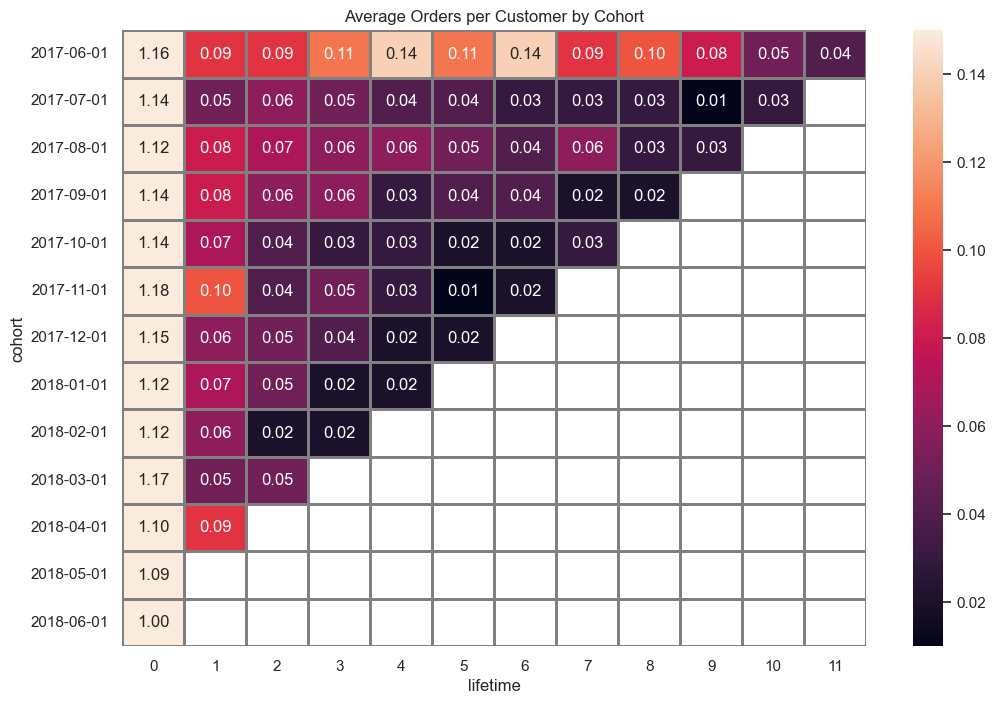

In [79]:
orders_customers.index=orders_customers.index.astype(str)

plt.figure(figsize=(12, 8))
plt.title('Average Orders per Customer by Cohort')
sns.heatmap(
    orders_customers, annot=True, fmt='.2f', vmax=0.15, linewidths=1, linecolor='gray'
)

plt.show()

For every cohort, the number of orders per customer in the first month averages more than 1, meaning that there were some customers that made more than one order. From the second month, the number drops to 0.1 or less for each cohort and in most of the cases it keeps dropping in the subsequent months. This indiates that very few customers from each cohort place orders in subsequent months. The first cohort (June 2017) is the only one that had an increase of number of orders per customers, reaching more than 10% of the customers placing order for some of the months.

 [⬆ Back to Contents](#back)

#### Average Purchase Size <a id='purchase_size'></a>

Next, let's examine the average amount spend by every cohort on each period. 

In [80]:
purchase_cohort = purchase_cohort.merge(cohort_size, on='cohort', how='left')

In [81]:
spent_per_month = purchase_cohort.groupby(['cohort', 'purchase_month', 'lifetime']).agg(total_spent=('revenue', 'sum'), avg_spent=('revenue', 'mean')).reset_index()
spent_per_month = spent_per_month.merge(cohort_size, on='cohort', how='left')
spent_per_month['avg_spent_per_customer'] = round((spent_per_month['total_spent'] / spent_per_month['cohort_size']), 2)

spent_per_month.sample(10)

cohort purchase_month  lifetime  total_spent  avg_spent  cohort_size  \
42 2017-10-01     2017-10-01         0     21716.20   4.374738         4340   
30 2017-08-01     2018-03-01         7       554.86   7.113590         1370   
1  2017-06-01     2017-07-01         1       981.82   5.547006         2023   
32 2017-08-01     2018-05-01         9       257.53   5.598478         1370   
43 2017-10-01     2017-11-01         1      2325.21   7.405127         4340   
25 2017-08-01     2017-10-01         2       628.12   6.281200         1370   
71 2018-02-01     2018-05-01         3       270.70   3.867143         3651   
11 2017-06-01     2018-05-01        11       519.62   6.042093         2023   
66 2018-01-01     2018-04-01         3       481.59   7.524844         3373   
68 2018-02-01     2018-02-01         0     15177.16   3.706266         3651   

    avg_spent_per_customer  
42                    5.00  
30                    0.41  
1                     0.49  
32                    0.19  
43                    0.54  
25                    0.46  
71                    0.07  
11                    0.26  
66                    0.14  
68                    4.16

In [82]:
spent_pivot = spent_per_month.pivot_table(
                                         index='cohort',
                                          columns='lifetime',
                                          values='avg_spent'
                                         )
#spent_pivot.fillna('')

In [83]:
purchase_cohort.head()

buy_ts  revenue                   uid first_purchase purchase_month  \
0 2017-06-01    17.00  10329302124590727494     2017-06-01     2017-06-01   
1 2017-06-01     0.55  11627257723692907447     2017-06-01     2017-06-01   
2 2017-06-01     0.37  17903680561304213844     2017-06-01     2017-06-01   
3 2017-06-01     0.55  16109239769442553005     2017-06-01     2017-06-01   
4 2017-06-01     0.37  14200605875248379450     2017-06-01     2017-06-01   

      cohort  lifetime  cohort_size  
0 2017-06-01         0         2023  
1 2017-06-01         0         2023  
2 2017-06-01         0         2023  
3 2017-06-01         0         2023  
4 2017-06-01         0         2023

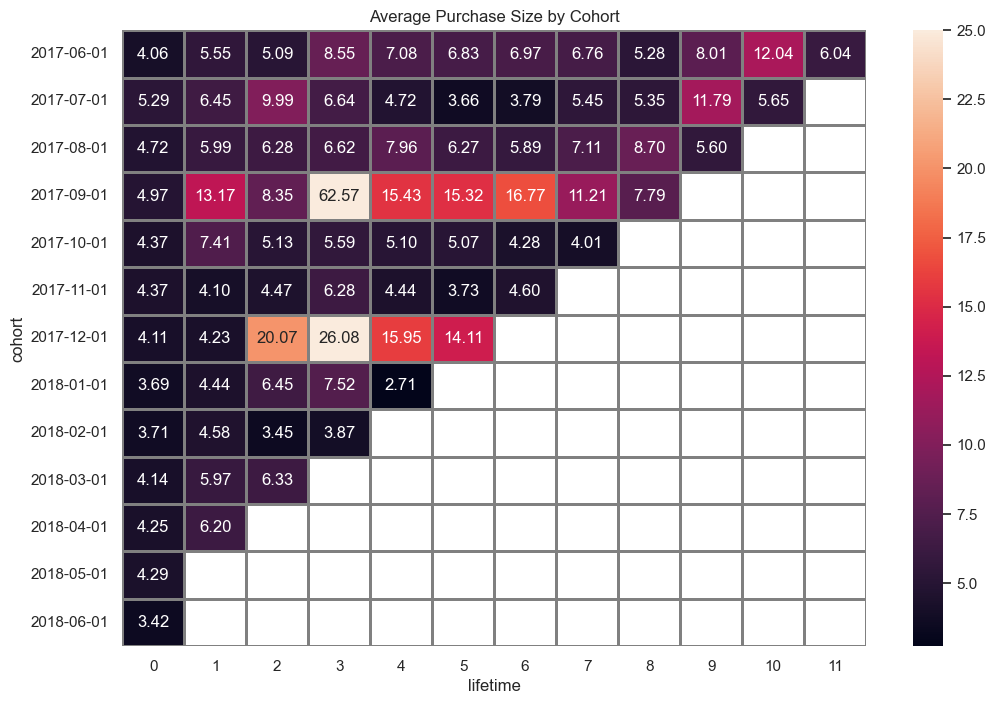

In [84]:
spent_pivot.index=spent_pivot.index.astype(str)

plt.figure(figsize=(12, 8))
plt.title('Average Purchase Size by Cohort')
sns.heatmap(
    spent_pivot, annot=True, fmt='.2f', vmax=25, linewidths=1, linecolor='gray'
)

plt.show()

The average purchase size is relatively constant for every cohort, averaging between \\$4 and \\$7 for most of the periods, with some reaching around \\$10 . The cohorts of September and December 2017 present a special behavior, in which the average spent reaches above $15 in several periods and even getting up to \\$62. This might be due to exceptionally large purchases made by a few customers.

 [⬆ Back to Contents](#back)

#### Customer Lifetime Value (LTV) <a id='ltv'></a>

We'll proceed to calculate the estimated average revenue that a customer generate throughout their lifetime.

In [85]:
ltv_pivot = spent_per_month.pivot_table(
                                         index='cohort',
                                          columns='lifetime',
                                          values='avg_spent_per_customer'                                         ).cumsum(axis=1)

#ltv_pivot.fillna('')

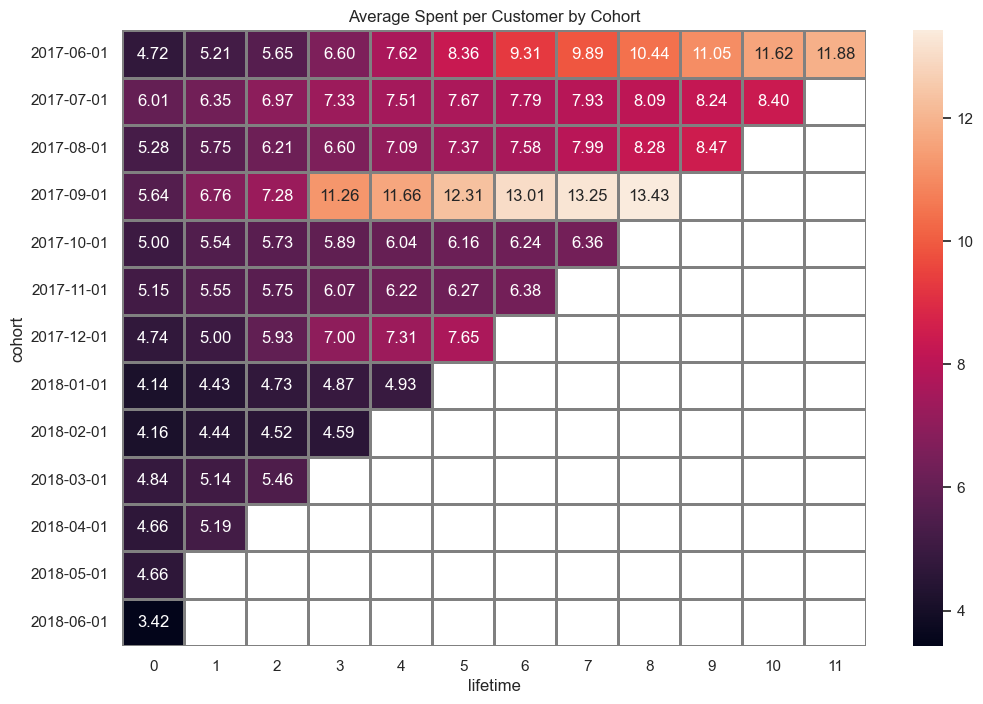

In [86]:
ltv_pivot.index=ltv_pivot.index.astype(str)

plt.figure(figsize=(12, 8))
plt.title('Average Spent per Customer by Cohort')
sns.heatmap(
    ltv_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray'
)

plt.show()

The average spent per customer shows a different picture compared to the average purchase size. We can see that the average spent per customer tends to increase every month that passes. In this case, the September cohort also presents a special behavior, having a relatively high average starting in a low age. 

The differences between these two metrics could imply variability in transaction amounts; in the periods with significantly higher average purchase sizes, a few customers might had made unusually large purchases, thus inflating the average purchase size for those periods, even if the majority of customers are spending relatively consistent amounts.

The cohorts of June and September might be caracterized by customers making smaller but more frequent purchases, resulting in a lower average purchase size but a higher average spent per customer. 

 [⬆ Back to Contents](#back)

### Metrics: Marketing <a id='metrics_marketing'></a>

Effectively allocating marketing resources requires an understanding of the campaigns performance and metrics such as Customer Acquisition Costs and Return on Investment. We will analyze some of these metrics to optimize our marketing expenditures and maximaze impact.

#### Total Marketing Expenses <a id='expenses'></a>

To allocate resources more effectively, first we need to understand how have the marketing funds been allocated across the different channels.

In [87]:
# getting the total costs per month per source
costs['month'] = costs['dt'].dt.to_period('M').dt.to_timestamp()
costs_comp = costs.groupby(['month', 'source_id']).agg({'costs': 'sum'}).reset_index()

In [88]:
costs_comp['month'] = costs_comp['month'].astype(str)

costs_pivot = costs_comp.pivot_table(
                               index='month',
                               columns='source_id',
                               values='costs',
                               aggfunc='sum',
                                margins=True,
                                margins_name='Total'
                                )
#costs_comp.head()

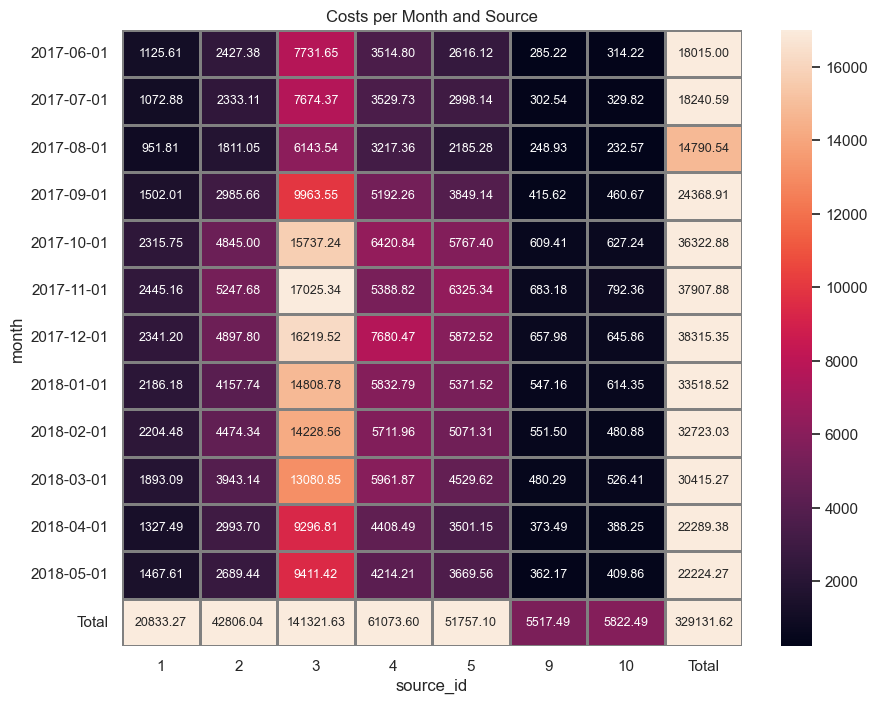

In [89]:
plt.figure(figsize=(10, 8))
plt.title('Costs per Month and Source')
sns.heatmap(
    costs_pivot, annot=True, fmt='.2f', vmax=17000, linewidths=1, linecolor='gray', annot_kws={"fontsize": 9}
)

plt.show()

Here we can see the total marketing costs for each month for each source, and their respective total amounts. The total marketing costs for the whole period was $329,131.52. We can observe that the biggest expenses on marketing were on Nov 2017 for the source 3. We can also see that overall, source 9 and 10 represent the lower costs and Aug 2017 was the month with the lower expenses.

In [90]:
costs_per_month = costs.groupby('month').agg({'costs': 'sum'}).reset_index()

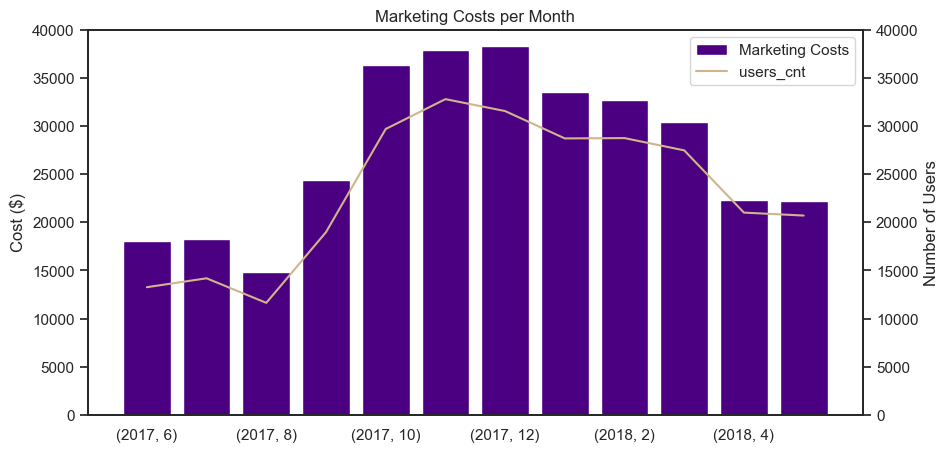

In [91]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# plotting marketing costs (bars)
ax1.bar(costs_per_month.index, costs_per_month['costs'], color='indigo', label='Marketing Costs')
ax1.set_title('Marketing Costs per Month')
ax1.set_xlabel('')
ax1.set_ylabel('Cost ($)')
ax1.set_ylim(0, 40000)

# creating a twin Axes for the number of users (line)
ax2 = ax1.twinx()
mau.plot(kind='line', ax=ax2, color='tan', rot=45, label='Number of Users', legend=False)
ax2.set_ylabel('Number of Users')
ax2.set_ylim(0, 40000)

# combining legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()

Here we see that the marketing costs seems to be related to the Monthly Active Users. The higher the marketing costs, the higher the number of users.

 [⬆ Back to Contents](#back)

#### Customer Acquisition Cost (CAC) <a id='cac'></a>

Let's dig into how much was spent to acquire new customers.

In [92]:
cac_per_month = costs_per_month.merge(cohort_size, how='left', left_on='month', right_on='cohort')
cac_per_month.drop(columns=['cohort'], inplace=True)
cac_per_month['cac'] = cac_per_month['costs'] / cac_per_month['cohort_size']
cac_per_month

month     costs  cohort_size        cac
0  2017-06-01  18015.00         2023   8.905091
1  2017-07-01  18240.59         1923   9.485486
2  2017-08-01  14790.54         1370  10.796015
3  2017-09-01  24368.91         2581   9.441654
4  2017-10-01  36322.88         4340   8.369327
5  2017-11-01  37907.88         4081   9.288870
6  2017-12-01  38315.35         4383   8.741809
7  2018-01-01  33518.52         3373   9.937302
8  2018-02-01  32723.03         3651   8.962758
9  2018-03-01  30415.27         3533   8.608907
10 2018-04-01  22289.38         2276   9.793225
11 2018-05-01  22224.27         2988   7.437841

In [93]:
cac_fig = px.line(cac_per_month, x='month', y='cac')

cac_fig.show()

Let's also calculate the CAC per source. For that, we first need to find the original source that brought the customers to the platform and get the number of customers that came from each. 

In [94]:
# getting the visit info for the users that made orders (customers)
customers = visits[visits['uid'].isin(orders['uid'])].loc[:,['device', 'session_date', 'source_id', 'uid']]
#customers

In [95]:
# getting the fisrt session date, source and device used
first_visit_customer = customers.groupby('uid').agg(first_session_date = ('session_date', 'min')).reset_index()

first_visit_customer = first_visit_customer.merge(customers, left_on=['uid', 'first_session_date'], right_on=['uid', 'session_date'])
first_visit_customer = first_visit_customer.drop(['session_date'], axis=1)

first_visit_customer['first_session_month'] = first_visit_customer['first_session_date'].dt.to_period('M').dt.to_timestamp()

first_visit_customer.head()

uid first_session_date   device  source_id first_session_month
0   313578113262317         2017-09-18  desktop          2          2017-09-01
1  1575281904278712         2017-06-03    touch         10          2017-06-01
2  1575281904278712         2017-06-03    touch         10          2017-06-01
3  2429014661409475         2017-10-11  desktop          3          2017-10-01
4  2464366381792757         2018-01-27  desktop          5          2018-01-01

In [96]:
# counting customers that arrive from each source in each month
customers_cnt = first_visit_customer.groupby(['first_session_month', 'source_id']).agg({'uid': 'count'}).reset_index()
#customers_cnt

In [97]:
costs_comp['month'] = pd.to_datetime(costs_comp['month'])

cac_per_month_source = costs_comp.merge(customers_cnt, left_on=['month', 'source_id'], right_on=['first_session_month', 'source_id'])

cac_per_month_source.drop(columns=['first_session_month'], inplace=True)
cac_per_month_source = cac_per_month_source.rename(columns={'uid': 'user_cnt'})

# calculating CAC
cac_per_month_source['cac'] = cac_per_month_source['costs'] / cac_per_month_source['user_cnt']

cac_per_month_source.head()

month  source_id    costs  user_cnt       cac
0 2017-06-01          1  1125.61       339  3.320383
1 2017-06-01          2  2427.38       438  5.541963
2 2017-06-01          3  7731.65       930  8.313602
3 2017-06-01          4  3514.80       690  5.093913
4 2017-06-01          5  2616.12       605  4.324165

In [98]:
# plotitng cac per source
fig = px.line(cac_per_month_source, x="month", y="cac", color='source_id', title='CAC per Month per Source')
fig.show()

Most of the sources have a slightly positive trend, meaning that the cost of acquiring customers has increased for each source during this period of time. There was a sudden increase for source 9 in april. This could have been due to several reasons, such as one-time event (special campaign). Without additional data, it is hard to identify the exact reason for this increase.

Source 10 seems to be most cost-effective, as the CAC values for this source is consistently lower than most of the other sources.

 [⬆ Back to Contents](#back)

#### Return on Investment (ROI) <a id='roi'></a>

After knowing how much was invested in each month and in each source, let's evaluate its efficiency by calculating the Return on Investments, both for the cohorts and for the sources.

In [99]:
ltv = spent_per_month[['cohort', 'purchase_month', 'lifetime', 'avg_spent_per_customer']]
ltv = ltv.rename(columns={'cohort': 'month','avg_spent_per_customer': 'ltv'})

In [100]:
roi = ltv.merge(cac_per_month, on='month')
roi['roi'] = roi['ltv'] / roi['cac']

In [101]:
roi_pivot = roi.pivot_table(
                           index='month',
                           columns='lifetime',
                           values='roi',
                           aggfunc='mean'
                           ).cumsum(axis=1).round(2) 
#roi_pivot.fillna('')

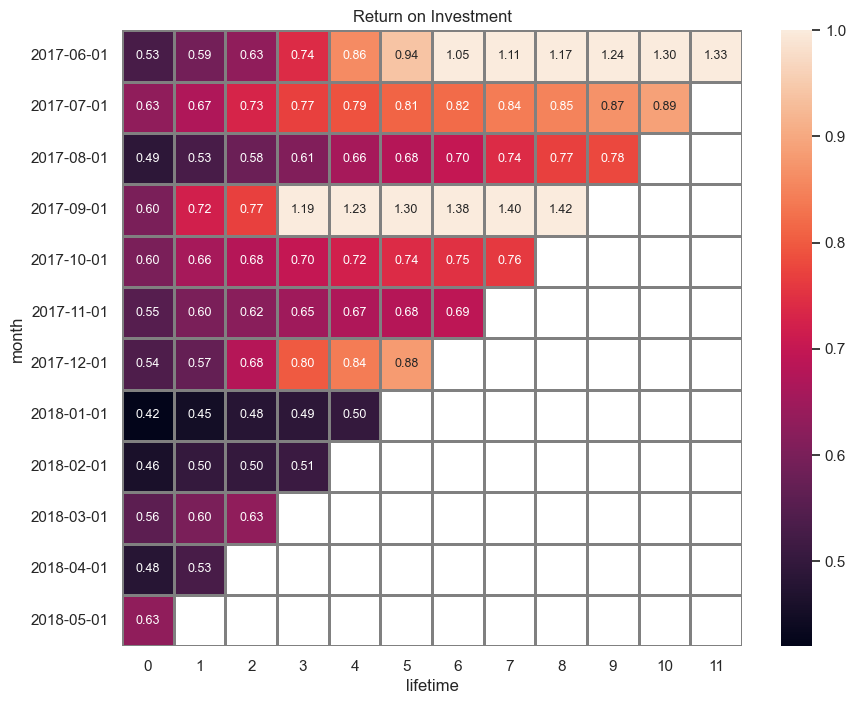

In [102]:
roi_pivot.index=roi_pivot.index.astype(str)

plt.figure(figsize=(10, 8))
plt.title('Return on Investment')
sns.heatmap(
    roi_pivot, annot=True, fmt='.2f', vmax=1, linewidths=1, linecolor='gray', annot_kws={"fontsize": 9}
)

plt.show()

We cannot see any particular pattern indicating at which month the cohorts start to be profitable. The only two cohorts that are currently generating more revenue than the initial investment are the June and September cohorts. These are the same cohorts that presented a higher average spent per customer. 

Finally, let's take a look at the ROI per source. Let's start this calculation by getting the total revenue generated by customers acquired through each source and then divide this value by the total cost of acquiring these customers.

In [103]:
# revenue generated by customers acquired by each source
ltv_source = orders.merge(customers[['uid', 'source_id']], on='uid')

ltv_source = ltv_source.groupby('source_id').agg({'revenue': 'sum', 'uid': 'nunique'}).reset_index()
ltv_source = ltv_source.rename(columns={'uid': 'user_cnt'})
ltv_source['ltv'] =  ltv_source['revenue'] / ltv_source['user_cnt']

ltv_source

source_id     revenue  user_cnt         ltv
0          1  2298200.17      7138  321.966961
1          2  2638189.21      7305  361.148420
2          3   296687.96     13846   21.427702
3          4   496690.17     14253   34.848114
4          5  1181477.14     10156  116.332920
5          7        1.22         1    1.220000
6          9    36342.25      2793   13.011905
7         10    14619.23      1773    8.245477

In [104]:
roi_source = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()
roi_source = roi_source.merge(ltv_source[['source_id', 'user_cnt', 'ltv']], on='source_id')
roi_source['cac'] = roi_source['costs'] / roi_source['user_cnt']
roi_source['romi'] = roi_source['ltv'] / roi_source['cac']
roi_source

source_id      costs  user_cnt         ltv        cac        romi
0          1   20833.27      7138  321.966961   2.918642  110.313944
1          2   42806.04      7305  361.148420   5.859828   61.631237
2          3  141321.63     13846   21.427702  10.206676    2.099381
3          4   61073.60     14253   34.848114   4.284965    8.132649
4          5   51757.10     10156  116.332920   5.096209   22.827344
5          9    5517.49      2793   13.011905   1.975471    6.586736
6         10    5822.49      1773    8.245477   3.283976    2.510821

In [105]:
fig = px.bar(roi_source, x='source_id', y='romi')
fig.update_xaxes(type='category')
fig.show()

Here, we observe that the source with the highest return on investment was source 1 by far, followed by source 2. Despite sources like 10 and 4 appearing to be more cost-efficient, as they have a lower CAC, the customers attracted from those sources might not be as valuable in terms of their purchasing behavior. Source 1 seems to be the most efficient channel, with a relatively low CAC and the highest ROMI.

 [⬆ Back to Contents](#back)

## Conclusions <a id='conclusion'></a>

In this analysis, we explored different aspects of our marketing strategies and customer behavior at Yandex Afisha, with the objective of opitmizing our marketing expenses.

We observed fluctuations in daily, weekly, and monthly active users, with a notable increase during autumn and winter months. We also observed that the user retention rates decline over time for each cohort, revealing an important pattern in the behavior of our users. This aligns with the conversion analysis, where we saw that a significant portion of users converted into customers shortly after their first session. The average purchase size remained relatively consistent across cohorts, although there were some cohort with a distinguised behavior. The customer lifetime value analysis revealed variations in spending behavior among cohorts.

After analyzing the marketing expenses across different channels, we observed correlations between marketing costs and user acquisition. Return on Investment analysis indicated that while certain sources appeared cost-efficient based on Customer Acquisition Cost, their effectiveness in driving valuable customer behavior differed. Source 1 demonstrated the highest return on investment, indicating its efficacy in attracting valuable customers.

**Recommendations**

Allocate resources towards channels with the highest return on investment, such as Source 1, while continuously monitoring and adjusting marketing expenditures based on performance.

Implement initiatives to stimulate repeat purchases and increase the number of orders per customer, thereby maximizing customer lifetime value.

 [⬆ Back to Contents](#back)